# Functions

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import os, sys, time
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
def get_k_folds_data(values_to_load, hyper_parameters_names_list, nbr_folds = 4):
    CHECKPOINT_K_FOLD_PATH_ROOT ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/k_folds_checkpoints/"
    BEST_MODEL_K_FOLD_PATH_ROOT ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/k_folds_checkpoints/"
    models_to_values = {}

    for hyper_parameter_name in hyper_parameters_names_list:
        models_to_values[hyper_parameter_name] = []
        for idx_validaton_set in range(nbr_folds):     
           #loading data from checkpoint
           CHECKPOINT_K_FOLD_PATH = CHECKPOINT_K_FOLD_PATH_ROOT + hyper_parameter_name + 'fold_' + str(idx_validaton_set) +'_all_data_final.pt'
           folds_data = torch.load(CHECKPOINT_K_FOLD_PATH, map_location=torch.device('cpu'))

           #extracting the evolution of the f1 score on the validation data
           fold_data = folds_data[values_to_load]
           models_to_values[hyper_parameter_name].append(fold_data)

    return models_to_values

def plot_k_folds(models_to_values, model_hyperparameter_name, plot_title="", x_axis_label ="", nbr_folds = 4, nbr_epochs = 15):
    plt.figure(figsize=(13, 8))
    plt.rcParams.update({'font.size': 16})
    x_axis = list(range(1, nbr_epochs+1))

    #plotting individual folds f1 score
    for idx in range(nbr_folds):
        fold_f1 = models_to_values[model_hyperparameter_name][idx][:nbr_epochs]
        max_f1 = np.max(fold_f1)*100
        plt.plot(x_axis, fold_f1, label=f"fold {idx}  (max = {max_f1:.1f}%)", lw=3, ls = "--")

    #plotting mean f1 score
    mean_f1 = np.mean(models_to_values[model_hyperparameter_name], axis = 0)[:nbr_epochs]
    max_f1_mean = np.max(mean_f1)*100
    plt.plot(x_axis, mean_f1, label=f"mean  (max = {max_f1_mean:.1f}%)", lw=5, color="black")

    #modifying plot
    plt.xlabel("epochs")
    plt.ylabel(x_axis_label)
    plt.title(plot_title)
    plt.legend()
    plt.show()

def plot_optimizer_k_folds_multiple(optimizer_dict_list, optimizer_name, values_plotted_list = None, plot_title="", x_axis_label ="", nbr_folds = 4, nbr_epochs = 15):
    plt.figure(figsize=(13, 8))
    plt.rcParams.update({'font.size': 14})
    x_axis = list(range(1, nbr_epochs+1))
    for idx_plt in range(len(optimizer_dict_list)):
        #plotting individual folds f1 score
        for idx in range(nbr_folds):
            fold_f1 = optimizer_dict_list[idx_plt][optimizer_name][idx][:nbr_epochs]
            max_f1 = np.max(fold_f1)*100
            plt.plot(x_axis, fold_f1, label=f"fold {idx} "+values_plotted_list[idx_plt]+f" (max = {max_f1:.1f}%)", lw=2, ls = "--")

        #plotting mean f1 score
        mean_f1 = np.mean(optimizer_dict_list[idx_plt][optimizer_name], axis = 0)[:nbr_epochs]
        max_f1_mean = np.max(mean_f1)*100
        plt.plot(x_axis, mean_f1, label=f"mean "+values_plotted_list[idx_plt]+f" (max = {max_f1_mean:.1f}%)", lw=5)

    #modifying plot
    plt.xlabel("epochs")
    plt.ylabel(x_axis_label)
    plt.title(plot_title)
    plt.legend()
    plt.show()


# Plots (k-fold on optimizers)

Thi is the data obtained from the k-fold validation on the following optimizers : SGD, ADAM, ADAM_W. The others hyperparameters where fixed in the following way : learning_rate : 1e-3, weight_decay : 1e-6, batch_size : 1, scheduler : None, data augmentation : full.

### SGD (momentum = 0.99)

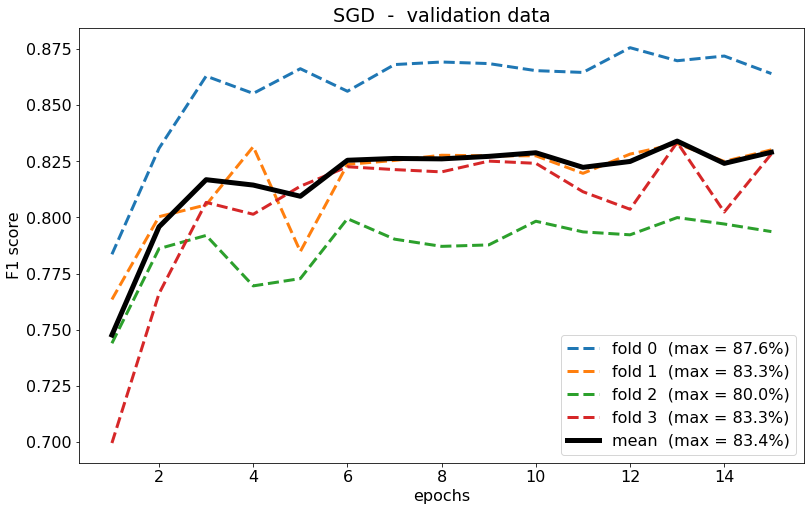

In [7]:
optimizer_names = ["SGD_"]
optimizers_f1s_val_dict_SGD_val = get_k_folds_data("f1_validation", optimizer_names)
plot_k_folds(optimizers_f1s_val_dict_SGD_val, "SGD_", plot_title = "SGD  -  validation data", x_axis_label = "F1 score")

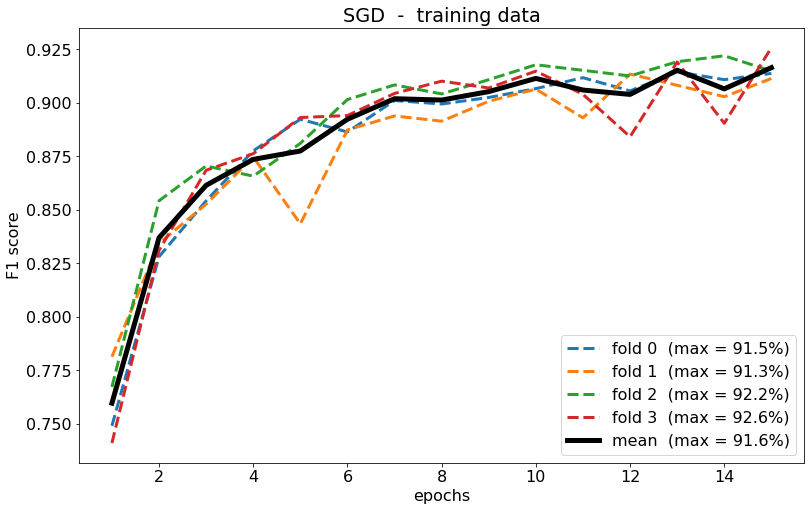

In [12]:
optimizer_names = ["SGD_"]
optimizers_f1s_val_dict_SGD_train = get_k_folds_data("f1_training", optimizer_names)
plot_k_folds(optimizers_f1s_val_dict_SGD_train, "SGD_", plot_title = "SGD  -  training data", x_axis_label = "F1 score")

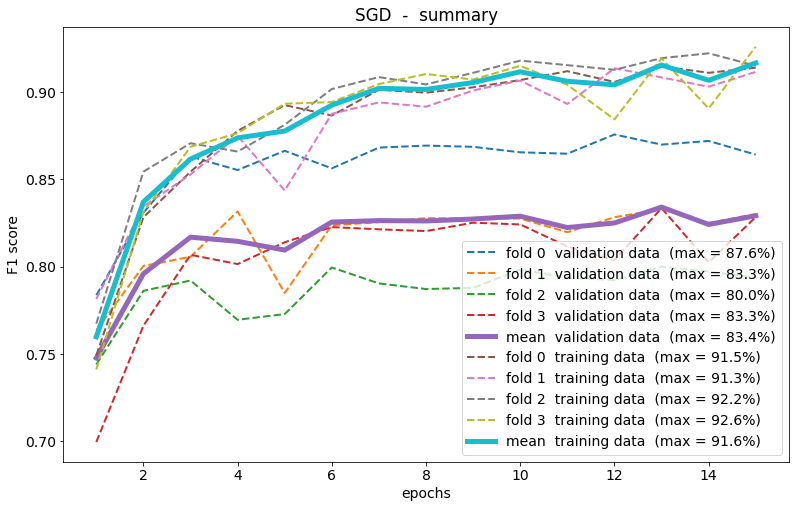

In [9]:
optimizer_dict_list = [optimizers_f1s_val_dict_SGD_val, optimizers_f1s_val_dict_SGD_train]
optimizer_name = "SGD_"
values_plotted_list = [" validation data ", " training data "]
plot_optimizer_k_folds_multiple(optimizer_dict_list, optimizer_name, values_plotted_list,  plot_title = "SGD  -  summary", x_axis_label = "F1 score")

### ADAM

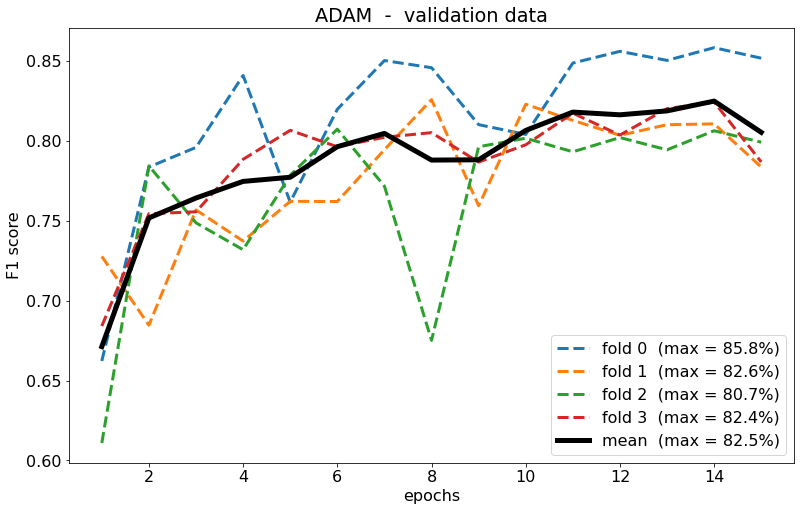

In [13]:
optimizer_names = ["ADAM_"]
optimizers_f1s_val_dict_ADAM_val = get_k_folds_data("f1_validation", optimizer_names)
plot_k_folds(optimizers_f1s_val_dict_ADAM_val, "ADAM_", plot_title = "ADAM  -  validation data", x_axis_label = "F1 score")

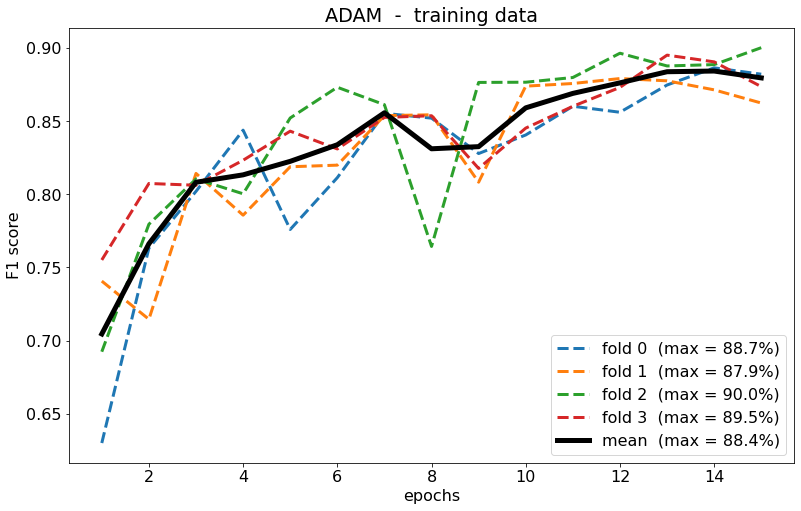

In [14]:
optimizer_names = ["ADAM_"]
optimizers_f1s_val_dict_ADAM_train = get_k_folds_data("f1_training", optimizer_names)
plot_k_folds(optimizers_f1s_val_dict_ADAM_train, "ADAM_", plot_title = "ADAM  -  training data", x_axis_label = "F1 score")

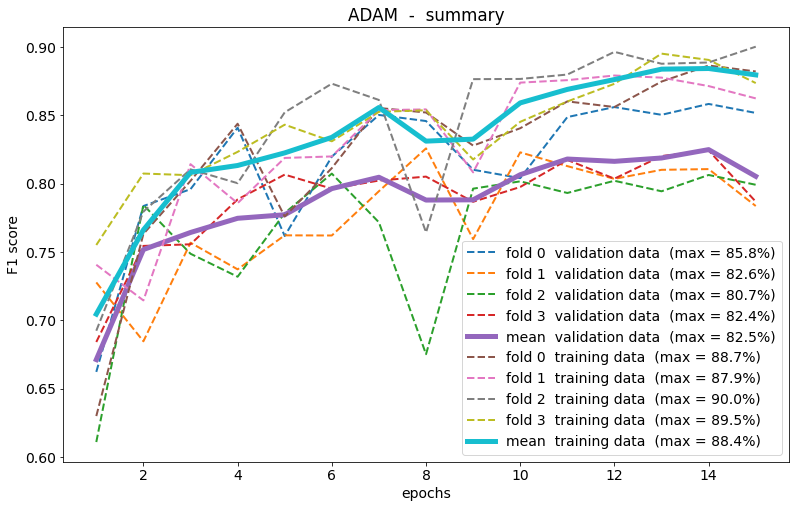

In [15]:
optimizer_dict_list = [optimizers_f1s_val_dict_ADAM_val, optimizers_f1s_val_dict_ADAM_train]
optimizer_name = "ADAM_"
values_plotted_list = [" validation data ", " training data "]
plot_optimizer_k_folds_multiple(optimizer_dict_list, optimizer_name, values_plotted_list,  plot_title = "ADAM  -  summary", x_axis_label = "F1 score")

### ADAM W

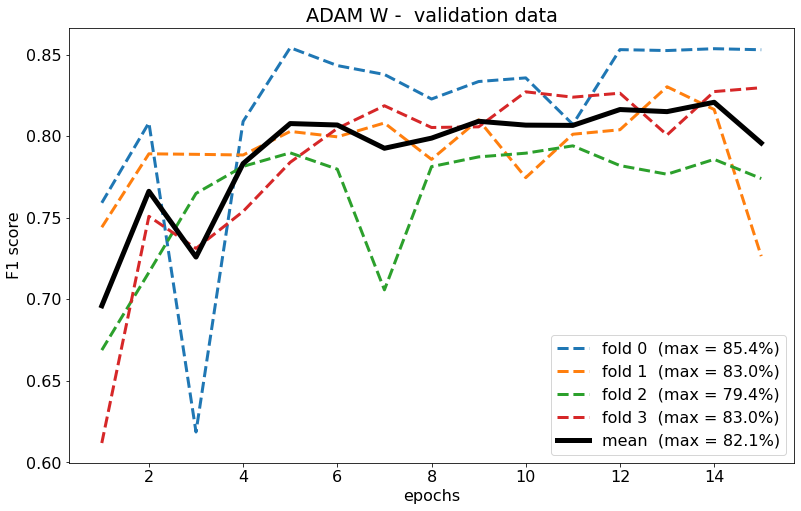

In [16]:
optimizer_names = ["ADAM_W_"]
optimizers_f1s_val_dict_ADAM_val = get_k_folds_data("f1_validation", optimizer_names)
plot_k_folds(optimizers_f1s_val_dict_ADAM_val, "ADAM_W_", plot_title = "ADAM W -  validation data", x_axis_label = "F1 score")

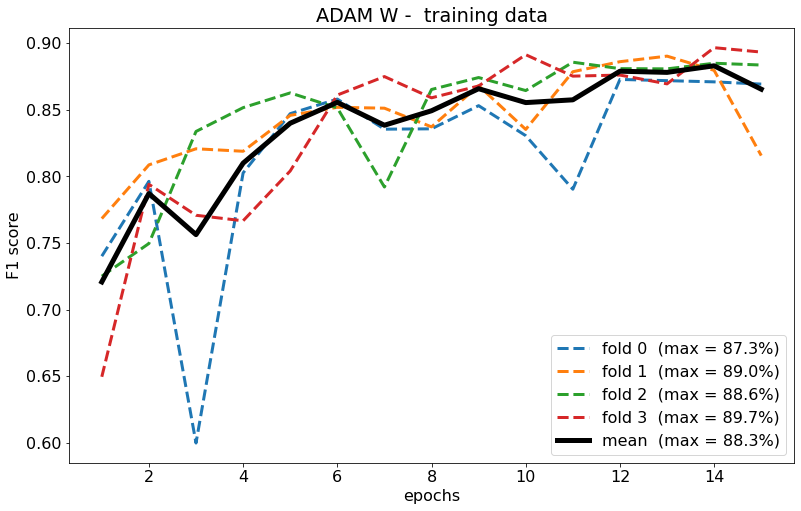

In [17]:
optimizer_names = ["ADAM_W_"]
optimizers_f1s_val_dict_ADAM_train = get_k_folds_data("f1_training", optimizer_names)
plot_k_folds(optimizers_f1s_val_dict_ADAM_train, "ADAM_W_", plot_title = "ADAM W -  training data", x_axis_label = "F1 score")

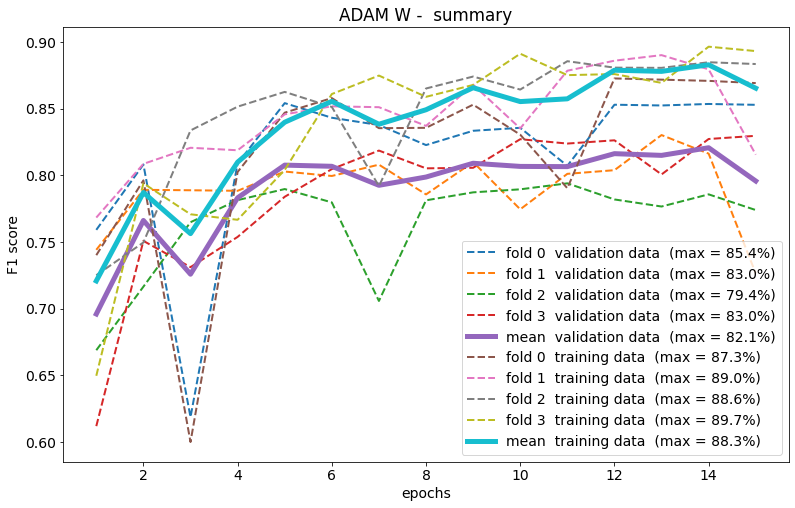

In [18]:
optimizer_dict_list = [optimizers_f1s_val_dict_ADAM_val, optimizers_f1s_val_dict_ADAM_train]
optimizer_name = "ADAM_W_"
values_plotted_list = [" validation data ", " training data "]
plot_optimizer_k_folds_multiple(optimizer_dict_list, optimizer_name, values_plotted_list,  plot_title = "ADAM W -  summary", x_axis_label = "F1 score")

# model analysis

In [ ]:
checkpoint_path ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/current_checkpoint_mirror_2.pt"
models_to_values = {}

folds_data = torch.load(checkpoint_path, map_location=torch.device('cpu'))

#extracting the evolution of the f1 score on the validation data
f1_validation = folds_data["f1_validation"]
f1_train = folds_data["f1_training"]

print(f1_validation)

[0.7088436966623557, 0.708561268091034, 0.8283173174559054, 0.8093580390861602, 0.699143554976386, 0.8483472900345592, 0.838154479371958, 0.8467942319576627, 0.8463324630627338, 0.8492074401952608, 0.8463241170352864, 0.8506326712914911, 0.8495028003705193, 0.8513497395066767, 0.8554046381719064, 0.8494332233429849, 0.8510024259195768, 0.8386267852721067, 0.8289003405033367, 0.8459957535871611, 0.8353989249376771, 0.8508317900445527]


22


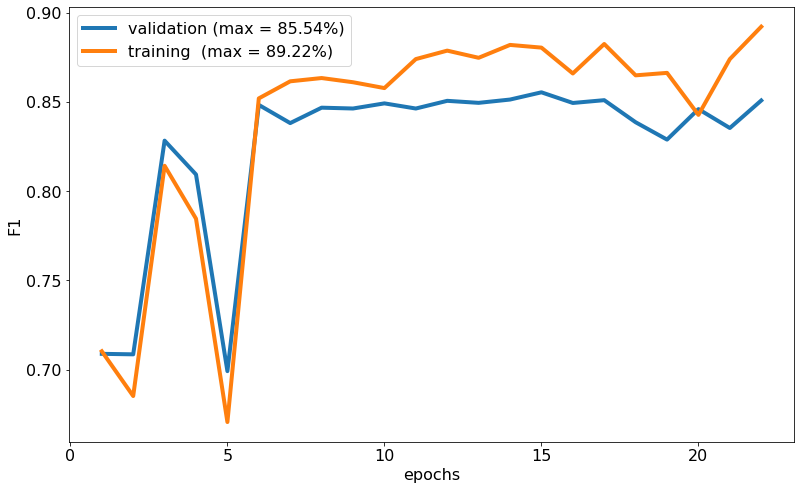

In [ ]:
plt.figure(figsize=(13, 8))
plt.rcParams.update({'font.size': 16})
nbr_epochs = len(f1_validation)
print(nbr_epochs)
x_axis = list(range(1, nbr_epochs+1))
max_f1_val = np.max(f1_validation)*100
plt.plot(x_axis, f1_validation, lw=4, label=f"validation (max = {max_f1_val:.2f}%)")
max_f1_train = np.max(f1_train)*100
plt.plot(x_axis, f1_train, lw=4, label=f"training  (max = {max_f1_train:.2f}%)")
#modifying plot
plt.xlabel("epochs")
plt.ylabel("F1")
#plt.title(plot_title)
plt.legend()
plt.show()